# 3d CNN

**Goals:** 

1. Play with the dimension uniformity of the three layers
2. Use the uniform dimension layers to train our first 3d CNN model!
3. Start doing some coarse playing with hyperparameters interactively to understand the problem better :-)

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Loading the other modules I have in parent directories
import sys
PYTHONPATH="../"
sys.path.append(PYTHONPATH)
from dataProcessing import getDataLoaders
from models import FCNet, CNN_3d, layer0_12x12, layer2_12x12, layer0_3x6, count_parameters
from train import check_accuracy, train
from plottingFcts import trainingMetrics, sigBkgEff, plotROC, plotConfusion

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
loader_train, loader_val, loader_test = getDataLoaders(batch_size=256)

In [4]:
print(layer0_3x6(16))

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): MaxP

In [5]:
myModel = CNN_3d(spatialDim=(3,6),preConvParams={'nF':32},
                 nFilters_1=32, filter_1= (3,3,3), stride_1=(1,1,1), padding_1=(1,1,1),
                 nFilters_2=16, filter_2= (3,3,2), stride_2=(2,2,2), padding_2=(1,1,1),
                 h1_dim=150, h2_dim=100)
print(myModel)

Output size after the first conv: 32,3.0,3.0,6.0
Output size after the second conv: 16,2.0,2.0,4.0
CNN_3d(
  (layer0_preConv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 32, kernel_size=(

In [6]:
myModel.modelName

'cnn3d_3x6_C32_F333_S111_P111_C16_F332_S222_P111_fc_150_100_dpt_0.5'

**Sanity check:**
Look at the model accuracy before you start training!

In [7]:
check_accuracy(loader_val, myModel)

cuda
Got 9873 / 30000 correct (32.91)


In [8]:
count_parameters(myModel)

139173

Perfect, close to 33%, as expected!

Next, checkt the size of the output.

In [ ]:
# for t, (l0, l1, l2, y) in enumerate(loader_train):
# #     l0_12x12 = layer0_12x12(l0)
# #     print("l0:",l0_12x12.shape)
    
# #     print(l2.shape)
# #     l2_12x12 = layer2_12x12(l2)
# #     print("l2:",l2_12x12.shape)
    
#     cnn_out = myModel(l0,l1,l2)
#     print(cnn_out.shape)
    
#     break

Sanity check: I want to make sure that I'm stitching the models together correctly, so check the parameters of the uniforming dimensionalaity layers so that I have a baseline that I can check against again after I'm done with the training.

In [ ]:
# print('Parameters in layer0_12x12:')
# for p in list(layer0_12x12.parameters()):
#     print(p)
    
# print('\nParameters in layer2_12x12:')
# for p in list(layer2_12x12.parameters()):
#     print(p)

## Train the model

Ok, this is exciting!!

In [9]:
optimizer = optim.Adam(myModel.parameters(), lr = 1e-5)

In [10]:
history, myModel = train(loader_train, loader_val, myModel, 
                         optimizer, epochs=60, returnBest=True)


Epoch 1/60:
Iteration 0, loss = 1.0840
cuda
Got 10000 / 30000 correct (33.33)

Iteration 100, loss = 0.9157
cuda
Got 18585 / 30000 correct (61.95)

Iteration 200, loss = 0.8501
cuda
Got 19951 / 30000 correct (66.50)

Iteration 300, loss = 0.8203
cuda
Got 20521 / 30000 correct (68.40)

Iteration 400, loss = 0.7730
cuda
Got 20898 / 30000 correct (69.66)

Iteration 500, loss = 0.7394
cuda
Got 21196 / 30000 correct (70.65)

Iteration 600, loss = 0.7157
cuda
Got 21451 / 30000 correct (71.50)

Iteration 700, loss = 0.6945
cuda
Got 21692 / 30000 correct (72.31)

cuda
Got 129787 / 180000 correct (72.10)
cuda
Got 21604 / 30000 correct (72.01)

Epoch 2/60:
Iteration 0, loss = 0.6908
cuda
Got 21586 / 30000 correct (71.95)

Iteration 100, loss = 0.6964
cuda
Got 21677 / 30000 correct (72.26)

Iteration 200, loss = 0.6275
cuda
Got 21925 / 30000 correct (73.08)

Iteration 300, loss = 0.6590
cuda
Got 21894 / 30000 correct (72.98)

Iteration 400, loss = 0.6426
cuda
Got 22114 / 30000 correct (73.71)

I

Iteration 700, loss = 0.4519
cuda
Got 23247 / 30000 correct (77.49)

cuda
Got 138986 / 180000 correct (77.21)
cuda
Got 23131 / 30000 correct (77.10)

Epoch 14/60:
Iteration 0, loss = 0.4595
cuda
Got 23115 / 30000 correct (77.05)

Iteration 100, loss = 0.4143
cuda
Got 23230 / 30000 correct (77.43)

Iteration 200, loss = 0.4347
cuda
Got 23230 / 30000 correct (77.43)

Iteration 300, loss = 0.4209
cuda
Got 23223 / 30000 correct (77.41)

Iteration 400, loss = 0.4086
cuda
Got 23248 / 30000 correct (77.49)

Iteration 500, loss = 0.4289
cuda
Got 23273 / 30000 correct (77.58)

Iteration 600, loss = 0.3824
cuda
Got 23204 / 30000 correct (77.35)

Iteration 700, loss = 0.4224
cuda
Got 23247 / 30000 correct (77.49)

cuda
Got 139716 / 180000 correct (77.62)
cuda
Got 23228 / 30000 correct (77.43)

Epoch 15/60:
Iteration 0, loss = 0.3953
cuda
Got 23211 / 30000 correct (77.37)

Iteration 100, loss = 0.4000
cuda
Got 23194 / 30000 correct (77.31)

Iteration 200, loss = 0.4023
cuda
Got 23326 / 30000 corre

Got 23297 / 30000 correct (77.66)

Iteration 500, loss = 0.4207
cuda
Got 23339 / 30000 correct (77.80)

Iteration 600, loss = 0.3890
cuda
Got 23292 / 30000 correct (77.64)

Iteration 700, loss = 0.3889
cuda
Got 23321 / 30000 correct (77.74)

cuda
Got 139244 / 180000 correct (77.36)
cuda
Got 23149 / 30000 correct (77.16)

Epoch 27/60:
Iteration 0, loss = 0.4013
cuda
Got 23095 / 30000 correct (76.98)

Iteration 100, loss = 0.4208
cuda
Got 23361 / 30000 correct (77.87)

Iteration 200, loss = 0.3757
cuda
Got 23346 / 30000 correct (77.82)

Iteration 300, loss = 0.3899
cuda
Got 23376 / 30000 correct (77.92)

Iteration 400, loss = 0.3659
cuda
Got 23290 / 30000 correct (77.63)

Iteration 500, loss = 0.3537
cuda
Got 23287 / 30000 correct (77.62)

Iteration 600, loss = 0.4172
cuda
Got 23341 / 30000 correct (77.80)

Iteration 700, loss = 0.4067
cuda
Got 23248 / 30000 correct (77.49)

cuda
Got 139732 / 180000 correct (77.63)
cuda
Got 23231 / 30000 correct (77.44)

Epoch 28/60:
Iteration 0, loss = 

Iteration 200, loss = 0.3725
cuda
Got 23439 / 30000 correct (78.13)

Iteration 300, loss = 0.4267
cuda
Got 23415 / 30000 correct (78.05)

Iteration 400, loss = 0.4212
cuda
Got 23359 / 30000 correct (77.86)

Iteration 500, loss = 0.3976
cuda
Got 23327 / 30000 correct (77.76)

Iteration 600, loss = 0.4138
cuda
Got 23376 / 30000 correct (77.92)

Iteration 700, loss = 0.3811
cuda
Got 23356 / 30000 correct (77.85)

cuda
Got 140189 / 180000 correct (77.88)
cuda
Got 23326 / 30000 correct (77.75)

Epoch 40/60:
Iteration 0, loss = 0.3566
cuda
Got 23375 / 30000 correct (77.92)

Iteration 100, loss = 0.4097
cuda
Got 23378 / 30000 correct (77.93)

Iteration 200, loss = 0.4229
cuda
Got 23416 / 30000 correct (78.05)

Iteration 300, loss = 0.3951
cuda
Got 23399 / 30000 correct (78.00)

Iteration 400, loss = 0.4499
cuda
Got 23401 / 30000 correct (78.00)

Iteration 500, loss = 0.3918
cuda
Got 23432 / 30000 correct (78.11)

Iteration 600, loss = 0.4006
cuda
Got 23378 / 30000 correct (77.93)

Iteration 7

Got 23397 / 30000 correct (77.99)

Iteration 100, loss = 0.3770
cuda
Got 23425 / 30000 correct (78.08)

Iteration 200, loss = 0.4117
cuda
Got 23413 / 30000 correct (78.04)

Iteration 300, loss = 0.3674
cuda
Got 23454 / 30000 correct (78.18)

Iteration 400, loss = 0.4037
cuda
Got 23407 / 30000 correct (78.02)

Iteration 500, loss = 0.3933
cuda
Got 23400 / 30000 correct (78.00)

Iteration 600, loss = 0.4193
cuda
Got 23411 / 30000 correct (78.04)

Iteration 700, loss = 0.3998
cuda
Got 23423 / 30000 correct (78.08)

cuda
Got 140502 / 180000 correct (78.06)
cuda
Got 23397 / 30000 correct (77.99)

Epoch 53/60:
Iteration 0, loss = 0.3753
cuda
Got 23377 / 30000 correct (77.92)

Iteration 100, loss = 0.4403
cuda
Got 23382 / 30000 correct (77.94)

Iteration 200, loss = 0.4067
cuda
Got 23449 / 30000 correct (78.16)

Iteration 300, loss = 0.3426
cuda
Got 23270 / 30000 correct (77.57)

Iteration 400, loss = 0.3631
cuda
Got 23389 / 30000 correct (77.96)

Iteration 500, loss = 0.3914
cuda
Got 23423 /

### Experiments
1. Try increasing the number of nodes in the output layer to see if you're losing too much info from these initial convolutions.
The acc got up to about 74.5%, but was then plateauing, so I stopped the the training. Then... I tried adding another hidden layer (so 3 fc layers before classification) to see if I was eroding too much of the model info when I was doing these up and down sampling pre-convolutions. The accuracy got up to 75.47%, so I'm going to try *decreasing* the learning rate by a factor of 10 (so now $\alpha=10^{-5}$) and trying another 10 epochs of training, and that got it down to 75.86% accuracy.
Just to be sure I knew *where* my improvements were coming from, and that I was comparing apples to apples, I tried retraining with two final fc layers using $\alpha=10^{-4}$ for 10 epochs, and then $\alpha=10^{-5}$ for another 10 epochs. This didn't help my validation accuracy at all, but I decided not to use 3 fc layers for my next few experiments, keeping in mind that these are the types of gains I should be able to achieve by tweaking the convolutional layers.

2. Next I tried doubling the number of filters in my two 3d convolutional layers to 32 and 16. This helped a little bit (75% accuracy), but I think the issue is that I need a better pre-convolutional architecture.

3. Try using 8 channels for each of the pre-conv layers
    - For layer0, I ended up using 4 filters for the downsampling convolution, and 8 filters for the upsampling convolution.
    Now I'm at 75% within 3 epochs... (not bad), and my validation acc after 10 epochs with $\alpha=1e-4$ is 75.68%. After training another 10 epochs with $\alpha=1e-5$, the val acc gets up to 75.87%
    
4. How far can this "new idea" take us? Try increasing the number of these preprocessing channels to 16 $\rightarrow$ 76.46% accuracy 

5. For layer2, instead of just duplicating this layer 16 times, try a filter with $3\times3$ filters that is weight preserving so you can learn different higher level features from this repn while preserving the spatial information.
I got to ()% accuracy, so I don't really think that that helped. But now that I'm  using more features, should I be using more overfitting safeguards, like batchnorm + dropout?
I tried that, it didn't really help, 74.84% val acc ;-(

When I tried a different lr schedule (15 epochs $\alpha = 2.5e-5$, and then another 15 with $\alpha=5e-6$), I got to 76.55% acc.

### Downsampling ALL layers

When we talked with Michael, he said he really didn't have an intuition for whether it would be helpful or not to upsample to the larger dimension to get the dimensions the same. The experiments that I conducted above show 

1. I wrote some new downsampling layers that use 2d convolutions and downsampling layers to compress the image. The default filters from the 3d-convolutions no longer fit, so I decided first to not compress the image, but use $3 \times 3 \times 3$ filters with a stride of 1 to compress info from across the image: 10 epochs 2.5e-5, 5 epochs 2.5e-6: 76.57%

2. Next: Try adding 2d BatchNorm in the pre-convolutional layers (it was acutally really stupid of me not to have tried this before) 5 epochs for 2.5e-5, 2.5e-6, 1e-6 $\rightarrow 77.3%$. *First time I broke 77% with a convolutional model!!!*
But I feel like the major lesson here is it's *very* important to be careful with these preconvolutional layers to not wash away too much of the information.

There are *a lot* of params in the current network right now: 186k! I saw with the fc when I increased the number of parameters, the performance got *worse*, so try to find some ways to *reduce* the number of parameters. 

The bottleneck is probably the connection from the 3d conv to the fc layers.

3. Increase the stride of the last 3d convolutional layer (need to adjust the filters a bit as well): filter_2= (3,3,2), stride_2=(2,2,2), padding_2=(1,1,1). This decreases the size of the image after this layer, and increases
~ 90k parameters, just about the same as my best performing fc net.
    - After training *only* for 5 epochs ($\alpha = 2.5e-5 \rightarrow$) 77.2% accuracy!!
    - Another 5 epochs $\alpha = 2.5e-6 \rightarrow 77.6%$ accuracy
    
4. Try increasing the number of filters for the 2d convolutions from 16 to 32. 
   After 5 epcohs, $\alpha = 2.5e-5$, I got 77.4% accuracy. Then 10 epochs, $\alpha = 1e-5$, 77.6%. 10 epochs $\alpha = 2e-6$, 77.84%. 3 epochs $\alpha = 1e-6$ (b/c I needed to go to class), 77.6%.

These parameter weights are changed from their initial values, so this looks ok!

In [13]:
check_accuracy(loader_val, myModel)

cuda
Got 23365 / 30000 correct (77.88)


### Model evaluation metrics

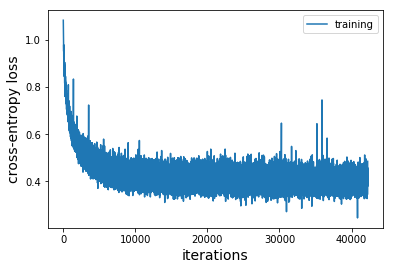

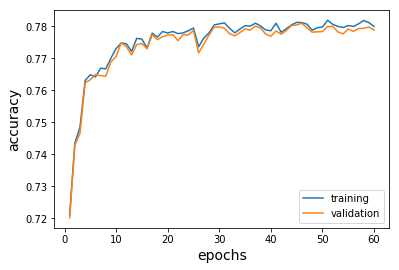

In [14]:
trainingMetrics(history)

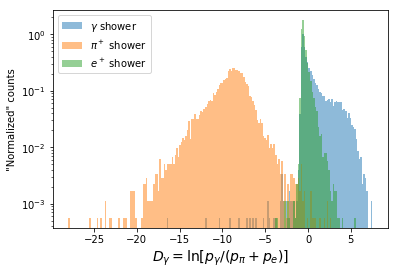

../plottingFcts.py:229: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


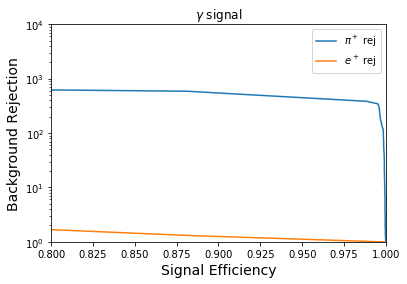

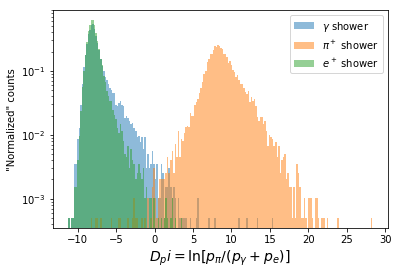

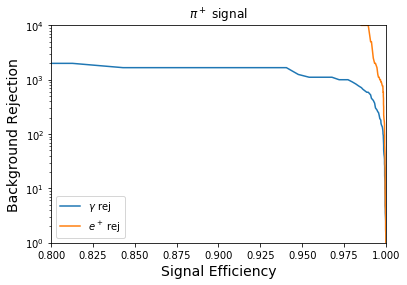

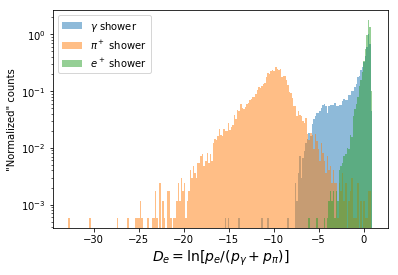

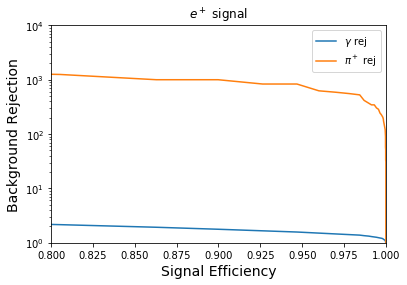

In [18]:
particles = ['gamma','pi','e']

for node in range(3):
    g_eff, pi_eff, e_eff = sigBkgEff(myModel, loader_val, node)
    mTag = '{}-sig_{}'.format(particles[node], myModel.modelName)
    
    # Plot the ROC curve using node as the signal and the other two as the bkg
    if node == 0:
        plotROC([g_eff, g_eff], [pi_eff, e_eff], ['$\pi^+$ rej', '$e^+$ rej'], title='$\gamma$ signal', tag=mTag)
    if node == 1:
        plotROC([pi_eff, pi_eff], [g_eff, e_eff], ['$\gamma$ rej', '$e^+$ rej'], title='$\pi^+$ signal', tag=mTag)
    elif node == 2:
        plotROC([e_eff, e_eff], [g_eff, pi_eff], ['$\gamma$ rej', '$\pi^+$ rej'], title='$e^+$ signal', tag=mTag)
        

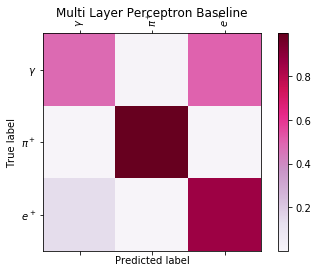

In [16]:
plotConfusion(myModel, loader_val, title="Multi Layer Perceptron Baseline")

### Goals:
- Print the number of parameters for each model
- Just change hyperparameters (by hand) to get more intuition for the problem
- Maybe try downsampling to (6,3) instead of upsampling to (12,12)
- Could try adding a learning rate scheduler
- Try changing the optimizer

# Recurrent CNN

- Apply three 2d convolutions to get a fixed size for the image vector!